In [1]:
!which python

/Users/itamar/anaconda2/bin/python


In [2]:
cd /Users/itamar/git/astro/urf/prf

/Users/itamar/git/astro/urf/PRF


In [3]:
!pwd
!ls

/Users/itamar/git/astro/urf/prf
LICENSE.md PRF        README.md  build      setup.py


In [4]:
import PRF.distance as distance
import PRF
import numpy
from imblearn.datasets import make_imbalance
from sklearn import datasets
from collections import Counter

In [5]:
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

numpy.set_printoptions(precision=2)

class_names = ['L1','L2','L3','S1','S2','S3']

# Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#RF = RandomForestClassifier(n_estimators=n_trees,n_jobs=-1)
#RF.fit(X_train, y_train)
#y_pred = RF.predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        #print("Normalized confusion matrix")
#    else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)
    plt.tight_layout()

In [7]:
n_samples= 100000
n_classes= 2
X, y = datasets.make_classification(n_samples = n_samples, n_features=10, n_classes=3,
                                    n_informative=10, n_redundant=0)
X2, y2 = datasets.make_classification(n_samples = n_samples, n_features=10, n_classes=3,
                                    n_informative=10, n_redundant=0)
X2[:,:5] = X2[:,:5] + 10
y2 = y2 + 3
X = numpy.vstack([X,X2])
y = numpy.hstack([y,y2])
print('Distribution before imbalancing: {}'.format(Counter(y)))
X_res, y_res = make_imbalance(X, y, sampling_strategy={0: 20000, 1: 1000, 2: 250, 3:500, 4:100, 5:50})
print('Distribution after imbalancing: {}'.format(Counter(y_res)))

Distribution before imbalancing: Counter({1: 33346, 4: 33346, 3: 33334, 0: 33330, 2: 33324, 5: 33320})
Distribution after imbalancing: Counter({0: 20000, 1: 1000, 3: 500, 2: 250, 4: 100, 5: 50})


In [11]:
n_trees = 100
n_samples_ = X_res.shape[0]
n_features = 'auto'
n_train = 20000
n_test = 20000
train_inds = numpy.random.choice(numpy.arange(n_samples_),n_train)
test_inds = numpy.random.choice(numpy.arange(n_samples_),n_test)

X_train = X_res[train_inds]
X_test  = X_res[test_inds]

y_train = y_res[train_inds]
y_test  = y_res[test_inds]
print('Distribution after imbalancing: {}'.format(Counter(y_train)))

Distribution after imbalancing: Counter({0: 18220, 1: 936, 3: 451, 2: 247, 4: 96, 5: 50})


# Supervised RF

In [12]:
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True)
prf_cls.fit(X=X_train, y=y_train)
print(prf_cls.score(X_test, y=y_test))
pred = prf_cls.predict(X_test)

0.98135


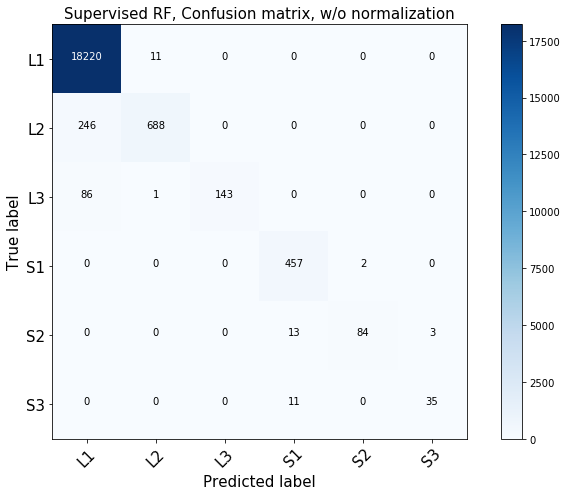

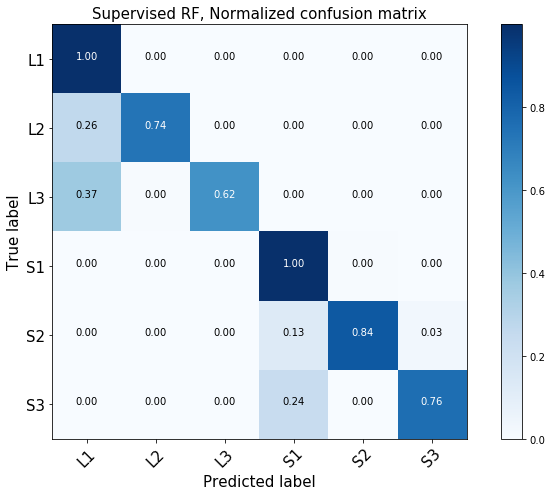

In [13]:
cnf_matrix = confusion_matrix(y_test, pred)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Supervised RF, Confusion matrix, w/o normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Supervised RF, Normalized confusion matrix')

plt.show()

# original Unsupervised RF

In [14]:
%%time
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0)
prf_cls.fit(X=X_test)
pred0 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.96125
CPU times: user 5min 27s, sys: 9.35 s, total: 5min 37s
Wall time: 5min 54s


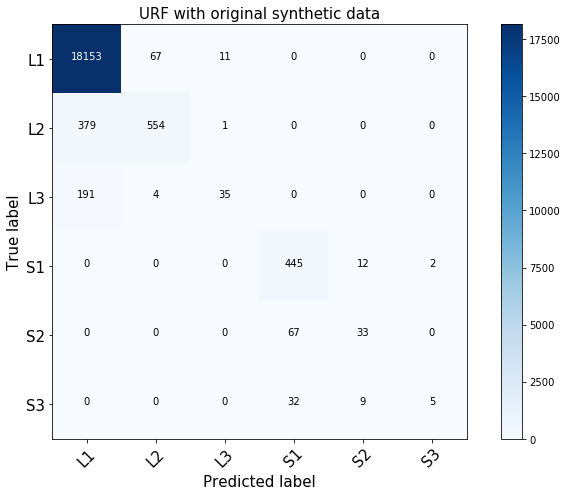

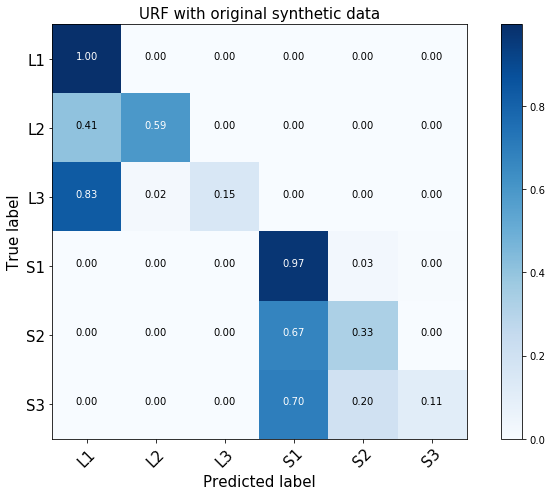

In [15]:
cnf_matrix = confusion_matrix(y_test, pred0)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with original synthetic data')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with original synthetic data')

plt.show()

# Unsupervised RF with synthetic data inside the tree nodes
* new synthetic data is created with probability 0.5 in each node

In [16]:
%%time
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0.5)
prf_cls.fit(X=X_test)
pred05 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.9698
CPU times: user 8min 7s, sys: 14.9 s, total: 8min 22s
Wall time: 8min 35s


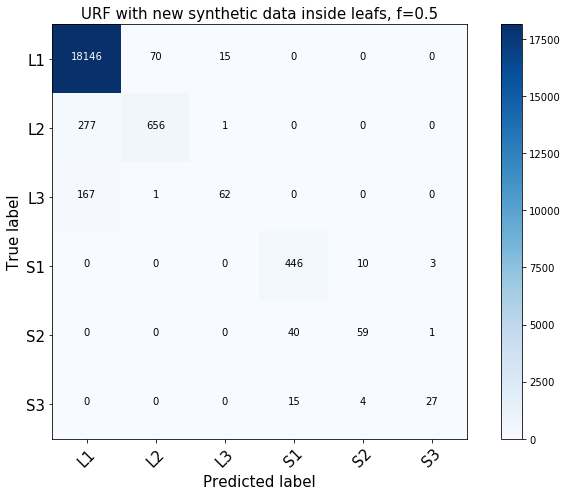

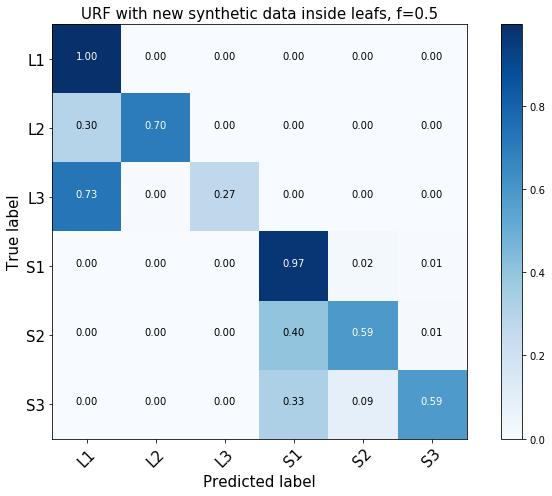

In [17]:
cnf_matrix = confusion_matrix(y_test, pred05)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with new synthetic data inside leafs, f=0.5')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with new synthetic data inside leafs, f=0.5')

plt.show()

# Unsupervised RF with synthetic data inside the tree nodes
* other fractions of tree nodes with new synthetic data

In [18]:
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0.1)
prf_cls.fit(X=X_test)
pred01 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.96605


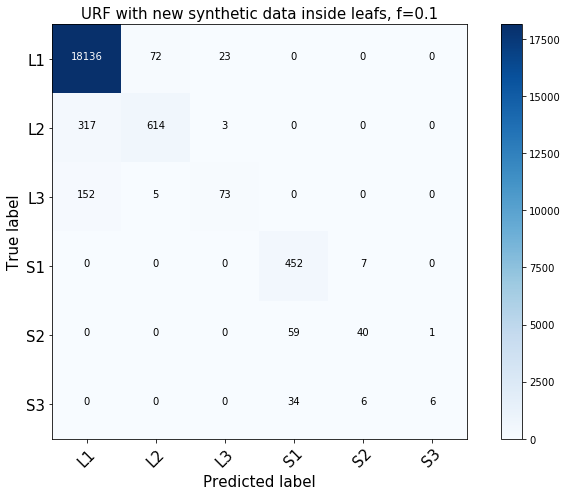

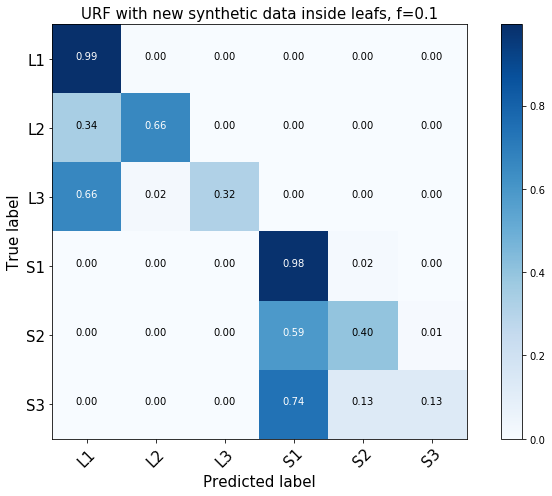

In [19]:
cnf_matrix = confusion_matrix(y_test, pred01)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with new synthetic data inside leafs, f=0.1')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with new synthetic data inside leafs, f=0.1')

plt.show()

In [20]:
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0.25)
prf_cls.fit(X=X_test)
pred025 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.96795


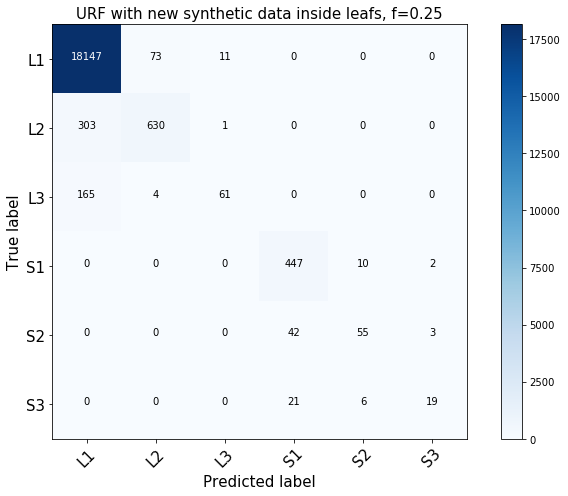

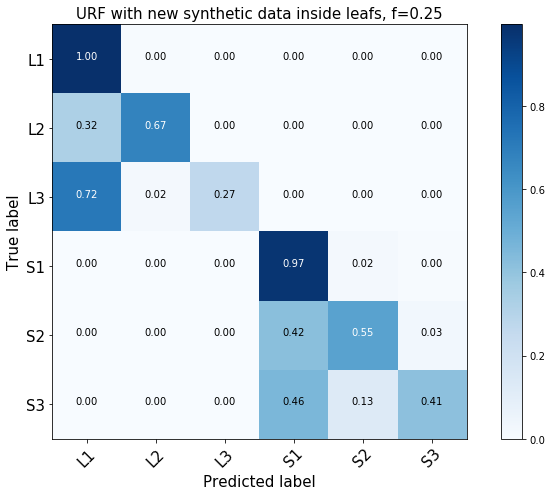

In [21]:
cnf_matrix = confusion_matrix(y_test, pred025)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with new synthetic data inside leafs, f=0.25')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with new synthetic data inside leafs, f=0.25')

plt.show()

In [22]:
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0.75)
prf_cls.fit(X=X_test)
pred075 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.9676


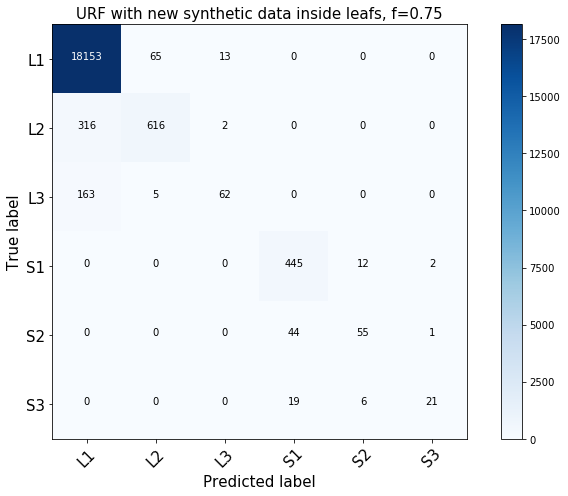

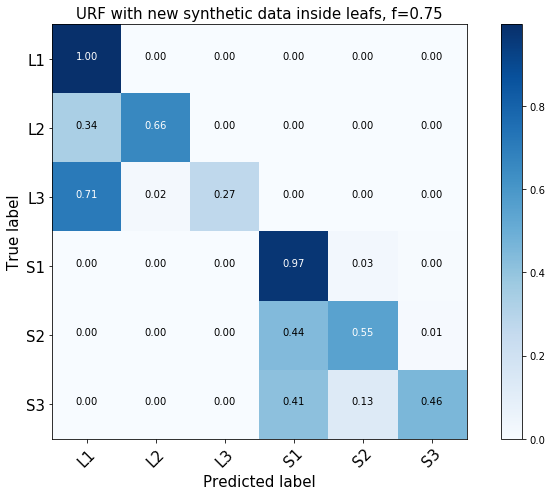

In [23]:
cnf_matrix = confusion_matrix(y_test, pred075)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with new synthetic data inside leafs, f=0.75')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with new synthetic data inside leafs, f=0.75')

plt.show()

In [24]:
n_trees = 100
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, new_syn_data_frac=0.9)
prf_cls.fit(X=X_test)
pred09 = distance.predict_urf(prf_cls, X_test, y_test)

Score: 0.9683


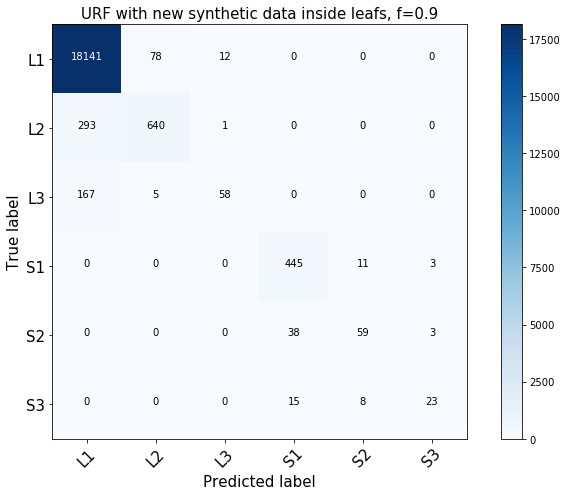

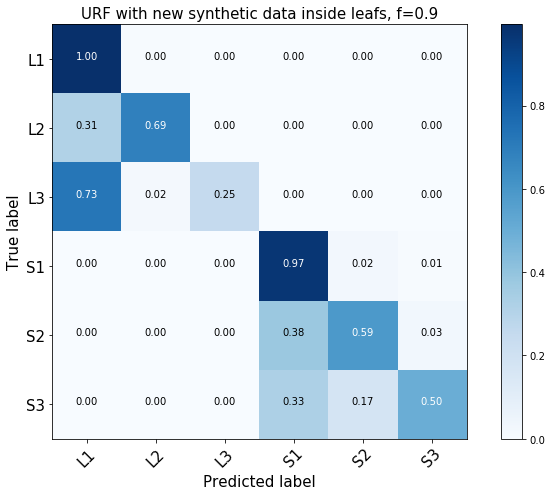

In [25]:
cnf_matrix = confusion_matrix(y_test, pred09)

# Plot non-normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='URF with new synthetic data inside leafs, f=0.9')

# Plot normalized confusion matrix
plt.figure(figsize = (10,7))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='URF with new synthetic data inside leafs, f=0.9')

plt.show()